# МЕТОД LSTM(all)

## Подключение диска для использования и сохранения данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd ./drive/MyDrive/InControl/

/content/drive/MyDrive/InControl


## Загрузка и данных из sql и фильтрация по мощности, удаление лишних колонок

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os
import numpy as np

cnx = sqlite3.connect('YUGRES_train.sqlite')
print(cnx)
train_df = pd.read_sql_query("SELECT * FROM 'data_train'", cnx, parse_dates=True)
train_df = train_df[train_df['20MBY10CE901_XQ01']>195]
time_ = pd.to_datetime(train_df['timestamp'])
# Создаем список названий столбцов, которые начинаются с "20"
selected_columns = [col for col in train_df.columns if col.startswith("20")]
# Создаем новый DataFrame, содержащий только выбранные столбцы
df_selected_train = train_df[selected_columns]
# df_selected_train.index = time_
df_selected_train['timestamp'] = time_
# test_time = test_df['timestamp']
# test_index = test_df['index']
# test_df = test_df.drop(columns = ['timestamp', 'index'])

## Удаление из данных для обучения сети, известных аномальных интервалов

In [ ]:
import pandas as pd

# Предположим, что у вас есть большой DataFrame с именем big_df

# Создаем DataFrame с интервалами для удаления
data_to_remove = {'Начало': ['2017-01-13 16:05:00', '2017-01-24 13:35:00', '2017-12-22 00:00:00',
                             '2017-12-22 00:00:00', '2017-03-05 00:00:00', '2017-03-03 00:00:00',
                             '2017-12-22 18:10:00', '2019-05-25 01:10:00', '2017-07-06 00:00:00',
                             '2019-05-26 00:00:00', '2017-03-03 00:00:00'],
                  'Конец': ['2017-01-21 08:50:00', '2017-02-06 05:00:00', '2018-02-19 00:00:00',
                            '2017-12-22 23:55:00', '2017-03-05 23:55:00', '2017-03-03 23:55:00',
                            '2018-02-20 20:55:00', '2019-05-28 14:45:00', '2017-07-06 23:55:00',
                            '2019-05-26 23:55:00', '2017-03-03 23:55:00']}

df_to_remove = pd.DataFrame(data_to_remove)

# Преобразуем столбцы "Начало" и "Конец" в формат datetime
df_to_remove['Начало'] = pd.to_datetime(df_to_remove['Начало'])
df_to_remove['Конец'] = pd.to_datetime(df_to_remove['Конец'])

# Удаляем интервалы из df
clear_df = df_selected_train[~df_selected_train.apply(lambda x: any((x['timestamp'] >= start) and (x['timestamp'] <= end) for start, end in zip(df_to_remove['Начало'], df_to_remove['Конец'])), axis=1)]

# В результате в df останутся только те строки, которые не пересекаются с интервалами из df_to_remove


## Очистка данных

In [ ]:
cd ./Train_LSTM-master/

/content/drive/MyDrive/InControl/Train_LSTM-master


In [ ]:
!pip install loguru

In [ ]:
!python clear_data.py --station Yugres

        Unnamed: 0  ...  20MBN51CF101_XQ01:1
0                0  ...             0.588030
1                1  ...             0.588030
2                2  ...             0.588030
3                3  ...             0.588030
4                4  ...             0.588030
...            ...  ...                  ...
226966      237563  ...             0.578704
226967      237564  ...             0.578704
226968      237565  ...             0.506366
226969      237566  ...             0.578704
226970      237567  ...             0.578704

[226971 rows x 224 columns]
....
*.
*
optimization finished, #iter = 4741
obj = 1035364.275674, rho = 505.885184
nSV = 4559, nBSV = 4527
[LibSVM][1 1 1 ... 1 1 1]
        Unnamed: 0  ...  check_index
0                0  ...            0
1                1  ...            1
2                2  ...            2
3                3  ...            3
4                4  ...            4
...            ...  ...          ...
226966      237563  ...       226966


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/InControl/Train_LSTM-master/YUGRES10/clear_data/clear_data.csv')
time_ = pd.to_datetime(df['timestamp'])

## Удаление лишних колонок

In [ ]:
import pandas as pd

# Предположим, что у вас есть DataFrame df

# Создаем список названий столбцов, которые начинаются с "20"
selected_columns = [col for col in df.columns if col.startswith("20")]

# Создаем новый DataFrame, содержащий только выбранные столбцы
df_selected = df[selected_columns]
df_selected.index = time_

## Подготовка данных
Предобработка данных:
Важно провести предобработку данных, включая:

Заполнение пропущенных значений, если они есть.

Масштабирование признаков, например, используя Min-Max Scaling или Standard Scaling.



In [ ]:
# Заполнение пропущенных значений
df_selected.fillna(method='ffill', inplace=True)

# Масштабирование данных (Min-Max Scaling)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_selected)



<ipython-input-9-e93390664689>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(method='ffill', inplace=True)


## Инициализация модели

In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

import tensorflow as tf

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(128, activation='relu', return_sequences=True,
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(64, activation='sigmoid', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(64, activation='sigmoid', return_sequences=True)(L3)
    L5 = LSTM(128, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

## Подготовка данных для подачи в сеть

In [ ]:
LAG = 1
X_train = scaled_data
def get_len_size(LAG,x_size):
  return int(x_size/LAG) * LAG
len_size = get_len_size(LAG, X_train.shape[0])
X_train = X_train[:len_size].reshape(int(X_train.shape[0] / LAG), int(LAG), X_train.shape[1])
print("Training data shape:", X_train.shape)


## Обучение модели


In [ ]:
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('.', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1,
                                                          min_delta=1e-4, mode='min')
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
    #                                                 save_weights_only=True,
    #                                                 verbose=1)
history = model.fit(X_train, X_train, epochs=200, batch_size=128,
                        validation_split=0.1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss]).history

with open(f'modelsummary.txt', 'w') as f:
  model.summary(print_fn=lambda x: f.write(x + '\n'))
model.save('lstm.h5')

Epoch 1/200
873/873 [==============================] - 22s 19ms/step - loss: 0.0678 - val_loss: 0.0372 - lr: 0.0010
Epoch 2/200
873/873 [==============================] - 19s 21ms/step - loss: 0.0379 - val_loss: 0.0317 - lr: 0.0010
Epoch 3/200
873/873 [==============================] - 18s 21ms/step - loss: 0.0371 - val_loss: 0.0283 - lr: 0.0010
Epoch 4/200
873/873 [==============================] - 18s 20ms/step - loss: 0.0329 - val_loss: 0.0209 - lr: 0.0010
Epoch 5/200
873/873 [==============================] - 18s 20ms/step - loss: 0.0313 - val_loss: 0.0205 - lr: 0.0010
Epoch 6/200
873/873 [==============================] - 13s 15ms/step - loss: 0.0306 - val_loss: 0.0222 - lr: 0.0010
Epoch 7/200
873/873 [==============================] - 14s 16ms/step - loss: 0.0303 - val_loss: 0.0247 - lr: 0.0010
Epoch 8/200
873/873 [==============================] - 13s 15ms/step - loss: 0.0301 - val_loss: 0.0245 - lr: 0.0010
Epoch 9/200
873/873 [==============================] - 18s 20ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Инференс


In [ ]:
from tensorflow.keras.models import load_model
model =load_model('/content/drive/MyDrive/InControl/Train_LSTM-master/lstm.h5')

In [ ]:
cd ./drive/MyDrive/InControl/

[Errno 2] No such file or directory: './drive/MyDrive/InControl/'
/content/drive/MyDrive/InControl


## Загрузка данных для теста

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import os
import numpy as np

cnx = sqlite3.connect('YUGRES_all.sqlite')
print(cnx.cursor)
test_df = pd.read_sql_query("SELECT * FROM 'data'", cnx, parse_dates=True)
test_df = test_df[test_df['20MBY10CE901_XQ01']>195]
time_ = pd.to_datetime(test_df['timestamp'])
# Создаем список названий столбцов, которые начинаются с "20"
selected_columns = [col for col in test_df.columns if col.startswith("20")]
# Создаем новый DataFrame, содержащий только выбранные столбцы
df_selected_test = test_df[selected_columns]
df_selected_test.index = time_
# df_selected_test['timestamp'] = time_

<built-in method cursor of sqlite3.Connection object at 0x7da827538b40>


In [ ]:
df_selected_test

,20MBY10CE901_XQ01,20MBY00CS901_XQ01,20MBL11CT010_XQ01,20MBL11CM001_XQ01,20MBL10CP003_XQ01,20MBL10CP004_XQ01,20MBL10CP005_XQ01,20MBL10CP010_XQ01,20MBA11DG002_XQ02,20MBA11DG002_XQ01,...,20MBH23AA101_XQ01,20MBH23AA102_XQ01,20MBH40AN001_XQ01,20MBH40AN002_XQ01,20MBH40CT101A_XQ01,20MBH40CT102A_XQ01,20MBH40CT103A_XQ01,20HNE20CQ010_XQ01_:1,20HBK10CQ011_XQ01_:1,20MBN51CF101_XQ01:1
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,406.039490,45.331322,-3.378902,68.417244,2.048249,0.411241,1.918764,5.449219,100.011299,100.0,...,23.806423,24.168114,73.640045,102.813942,130.200012,130.800018,130.300018,11.351465,7.580911,0.588030
2017-01-01 00:05:00,406.039490,45.331322,-3.378902,68.475113,2.036314,0.411241,1.907190,5.449219,100.075623,100.0,...,23.810040,24.168114,72.999855,102.813942,130.200012,130.600006,130.100006,11.351465,7.580911,0.588030
2017-01-01 00:10:00,406.039490,45.331322,-3.406754,67.983215,2.013889,0.397135,1.907190,5.449219,100.032745,100.0,...,23.806423,24.164495,74.153648,102.813942,130.399994,130.600006,130.100006,11.351465,7.580911,0.588030
2017-01-01 00:15:00,406.039490,45.331322,-3.406754,68.326820,2.040654,0.421369,1.907190,5.449219,100.032745,100.0,...,23.817274,24.168114,74.153648,102.813942,130.100006,130.600006,130.100006,11.351465,7.580911,0.588030
2017-01-01 00:20:00,405.801483,45.331322,-3.406754,68.395546,2.063440,0.421369,1.907190,5.429688,100.097046,100.0,...,23.806423,24.168114,74.280235,102.813942,130.100006,130.600006,130.100006,11.351465,7.580911,0.588030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 20:40:00,388.705505,50.043404,15.766060,78.385414,1.300998,0.412688,2.184968,5.018085,100.044037,100.0,...,22.175201,22.341579,97.909431,60.485386,129.899994,130.200012,129.500000,11.738527,0.124785,0.578704
2019-07-23 20:45:00,388.545990,50.000004,15.766060,79.130493,1.300998,0.412688,2.197989,5.018085,100.044037,100.0,...,22.175201,22.341579,97.909431,60.745804,129.700012,129.899994,129.500000,11.302330,-0.343158,0.578704
2019-07-23 20:50:00,388.191528,50.021706,15.766060,78.088829,1.286169,0.428602,2.197989,5.018085,100.044037,100.0,...,22.175201,22.341579,97.909431,60.865162,129.700012,130.000000,129.500000,11.699754,0.124785,0.506366


In [ ]:
 scaled_data = pd.DataFrame(
            data=scaler.transform(df_selected_test),
            columns=df_selected_test.columns
        )


In [ ]:
X = scaled_data.to_numpy()
len_size = get_len_size(LAG, X.shape[0])
X = X[:len_size].reshape(int(X.shape[0] / LAG), LAG, X.shape[1])
preds = model.predict(X, verbose=1)
preds = preds[:, 0, :]
yhat = X[:, 0, :]
loss = np.mean(np.abs(yhat - preds), axis=1)
each_loss = np.abs(yhat - preds)


6381/6381 [==============================] - 18s 3ms/step


In [ ]:
df_lstm = pd.DataFrame(each_loss, columns=df_selected_test.columns)
df_lstm.index = time_
df_lstm

,20MBY10CE901_XQ01,20MBY00CS901_XQ01,20MBL11CT010_XQ01,20MBL11CM001_XQ01,20MBL10CP003_XQ01,20MBL10CP004_XQ01,20MBL10CP005_XQ01,20MBL10CP010_XQ01,20MBA11DG002_XQ02,20MBA11DG002_XQ01,...,20MBH23AA101_XQ01,20MBH23AA102_XQ01,20MBH40AN001_XQ01,20MBH40AN002_XQ01,20MBH40CT101A_XQ01,20MBH40CT102A_XQ01,20MBH40CT103A_XQ01,20HNE20CQ010_XQ01_:1,20HBK10CQ011_XQ01_:1,20MBN51CF101_XQ01:1
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.000688,0.008372,0.028136,0.019560,0.105618,0.194171,0.080985,0.005684,0.010905,0.013753,...,0.012461,0.014814,0.041123,0.126883,0.000346,0.000773,0.001469,0.000350,0.000336,0.000139
2017-01-01 00:05:00,0.000782,0.008273,0.028864,0.018699,0.103521,0.193384,0.083051,0.005313,0.011576,0.013920,...,0.012513,0.014839,0.047893,0.126555,0.000433,0.000507,0.000177,0.000342,0.000338,0.000135
2017-01-01 00:10:00,0.000084,0.008408,0.027123,0.024832,0.096840,0.211891,0.085486,0.006941,0.009936,0.012353,...,0.012443,0.014764,0.036485,0.126593,0.001650,0.000651,0.000063,0.000345,0.000323,0.000143
2017-01-01 00:15:00,0.000751,0.007919,0.028186,0.020261,0.099372,0.191077,0.088596,0.009402,0.008367,0.010434,...,0.012728,0.015023,0.037980,0.124778,0.000248,0.000476,0.000244,0.000302,0.000313,0.000146
2017-01-01 00:20:00,0.000308,0.008125,0.029307,0.019285,0.108250,0.184327,0.084192,0.007350,0.010599,0.012540,...,0.012580,0.014936,0.035997,0.125760,0.000197,0.000462,0.000230,0.000344,0.000347,0.000139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 20:40:00,0.018009,0.000403,0.005240,0.268753,0.032306,0.102552,0.097215,0.048987,0.006533,0.007081,...,0.040949,0.039898,0.000377,0.214967,0.000132,0.000698,0.001887,0.020316,0.025255,0.012715
2019-07-23 20:45:00,0.019034,0.001105,0.004192,0.275509,0.032015,0.101397,0.099362,0.048593,0.006628,0.007184,...,0.040813,0.039707,0.000130,0.212531,0.001430,0.001561,0.002118,0.002848,0.026821,0.012723
2019-07-23 20:50:00,0.019822,0.000413,0.005686,0.265556,0.027957,0.117505,0.098888,0.047996,0.007525,0.008293,...,0.041097,0.040038,0.001084,0.212218,0.001122,0.000589,0.001794,0.018326,0.025258,0.112727


In [ ]:
import scipy
def scaler_loss(target_value, scaler_name, range_loss = 100):
            if scaler_name == 'cdf':
                hist = np.histogram(target_value, bins=range_loss)
                # logger.debug(target_value)
                scaler_loss = scipy.stats.rv_histogram(hist)
                # logger.debug(hist)
                target_value = scaler_loss.cdf(target_value)*range_loss
                scaler_loss = hist
            elif scaler_name == 'minmax':
                scaler_loss = MinMaxScaler(feature_range=(0, range_loss))
                loss_2d = np.reshape(target_value, (-1,1))
                scaler_loss.fit(loss_2d)
                target_value = scaler_loss.transform(loss_2d)
            return target_value, scaler_loss

In [ ]:
target_value, scaler_loss = scaler_loss(loss, 'cdf')
df_lstm['target_value'] = target_value

In [ ]:
df_lstm['target_value']

timestamp
2017-01-01 00:00:00    0.295307
2017-01-01 00:05:00    0.297749
2017-01-01 00:10:00    0.289733
2017-01-01 00:15:00    0.286819
2017-01-01 00:20:00    0.293368
                         ...   
2019-07-23 20:40:00    0.205736
2019-07-23 20:45:00    0.199562
2019-07-23 20:50:00    0.211514
2019-07-23 20:55:00    0.202402
2019-07-23 21:00:00    0.204367
Name: target_value, Length: 204186, dtype: float64

In [ ]:
df_lstm.to_csv('lstm_predict.csv')

# Тесты

In [5]:
df_lstm = pd.read_csv('lstm_predict.csv')
df = pd.read_csv('lstm_predict.csv')

In [ ]:
df.columns

Index(['timestamp', '20MBY10CE901_XQ01', '20MBY00CS901_XQ01',
       '20MBL11CT010_XQ01', '20MBL11CM001_XQ01', '20MBL10CP003_XQ01',
       '20MBL10CP004_XQ01', '20MBL10CP005_XQ01', '20MBL10CP010_XQ01',
       '20MBA11DG002_XQ02',
       ...
       '20MBH23AA102_XQ01', '20MBH40AN001_XQ01', '20MBH40AN002_XQ01',
       '20MBH40CT101A_XQ01', '20MBH40CT102A_XQ01', '20MBH40CT103A_XQ01',
       '20HNE20CQ010_XQ01_:1', '20HBK10CQ011_XQ01_:1', '20MBN51CF101_XQ01:1',
       'target_value'],
      dtype='object', length=223)

In [ ]:
target_value = df['target_value']

In [6]:
window_size = 256
df['target_mean'] = df['target_value'].rolling(window=window_size).mean()


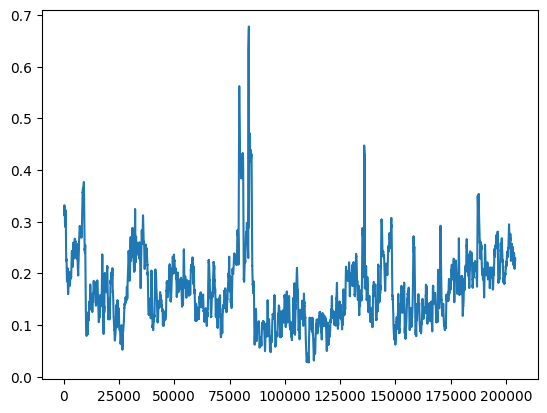

In [7]:
plt.plot(df['target_mean'])

In [ ]:
min_interval_length = pd.Timedelta(minutes=1200)  # Минимальная длина интервала
# df=df_lstm

long_intervals = []
df['max_in_window'] = df['target_mean'].rolling(window=4).max()

# Помечаем записи, где текущее значение равно максимальному в окне
df['is_max'] = df['target_mean'] == df['max_in_window']

# Применяем fillna для замены NaN на False в начале
df['is_max'] = df['is_max'].fillna(False)
start = None
for index, row in df.iterrows():
    if row['is_max']:
        if start is None:
            start = row['timestamp']
    elif start is not None:
        end = row['timestamp']
        if end - start >= min_interval_length:
            long_intervals.append((start, end))
        start = None

# Если последний интервал заканчивается максимальным значением
if start is not None:
    end = df['timestamp'].iloc[-1]
    if end - start >= min_interval_length:
        long_intervals.append((start, end))

# Выводим найденные длинные интервалы с максимальными значениями
for interval in long_intervals:
    print(f"Длинный интервал: {interval[0]} - {interval[1]}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



# Определите интервалы
intervals = long_intervals

# Фильтруем DataFrame, чтобы получить только строки, которые находятся в интервалах
filtered_df = pd.DataFrame()

for interval in intervals:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df = pd.concat([filtered_df, interval_df])

# Отрисовываем полученные данные
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['target_mean'], label='Все данные', linestyle='--')
plt.scatter(filtered_df['timestamp'], filtered_df['target_value'], color='red', label='Данные в интервалах')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.title('Отрисовка данных в интервалах')
plt.grid(True)
plt.show()

In [ ]:
long_intervals

[(Timestamp('2018-08-31 12:55:00'), Timestamp('2018-08-31 14:05:00')),
 (Timestamp('2019-02-05 21:20:00'), Timestamp('2019-02-09 07:55:00')),
 (Timestamp('2019-04-12 21:30:00'), Timestamp('2019-04-15 19:55:00')),
 (Timestamp('2019-07-19 09:35:00'), Timestamp('2019-07-19 12:00:00'))]

In [ ]:
data_to_remove = {'Начало': ['2017-01-13 16:05:00', '2017-01-24 13:35:00', '2017-12-22 00:00:00',
                             '2017-12-22 00:00:00', '2017-03-05 00:00:00', '2017-03-03 00:00:00',
                             '2017-12-22 18:10:00', '2019-05-25 01:10:00', '2017-07-06 00:00:00',
                             '2019-05-26 00:00:00', '2017-03-03 00:00:00'],
                  'Конец': ['2017-01-21 08:50:00', '2017-02-06 05:00:00', '2018-02-19 00:00:00',
                            '2017-12-22 23:55:00', '2017-03-05 23:55:00', '2017-03-03 23:55:00',
                            '2018-02-20 20:55:00', '2019-05-28 14:45:00', '2017-07-06 23:55:00',
                            '2019-05-26 23:55:00', '2017-03-03 23:55:00']}



In [8]:
import pandas as pd

data_to_remove = {
    'Начало': ['2017-01-13 16:05:00', '2017-01-24 13:35:00', '2017-12-22 00:00:00',
               '2017-12-22 00:00:00', '2017-03-05 00:00:00', '2017-03-03 00:00:00',
               '2017-12-22 18:10:00', '2019-05-25 01:10:00', '2017-07-06 00:00:00',
               '2019-05-26 00:00:00', '2017-03-03 00:00:00'],
    'Конец': ['2017-01-21 08:50:00', '2017-02-06 05:00:00', '2018-02-19 00:00:00',
             '2017-12-22 23:55:00', '2017-03-05 23:55:00', '2017-03-03 23:55:00',
             '2018-02-20 20:55:00', '2019-05-28 14:45:00', '2017-07-06 23:55:00',
             '2019-05-26 23:55:00', '2017-03-03 23:55:00']
}

# Преобразуем даты в формат Timestamp
date_tuples = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end in zip(data_to_remove['Начало'], data_to_remove['Конец'])]

print(date_tuples)


[(Timestamp('2017-01-13 16:05:00'), Timestamp('2017-01-21 08:50:00')), (Timestamp('2017-01-24 13:35:00'), Timestamp('2017-02-06 05:00:00')), (Timestamp('2017-12-22 00:00:00'), Timestamp('2018-02-19 00:00:00')), (Timestamp('2017-12-22 00:00:00'), Timestamp('2017-12-22 23:55:00')), (Timestamp('2017-03-05 00:00:00'), Timestamp('2017-03-05 23:55:00')), (Timestamp('2017-03-03 00:00:00'), Timestamp('2017-03-03 23:55:00')), (Timestamp('2017-12-22 18:10:00'), Timestamp('2018-02-20 20:55:00')), (Timestamp('2019-05-25 01:10:00'), Timestamp('2019-05-28 14:45:00')), (Timestamp('2017-07-06 00:00:00'), Timestamp('2017-07-06 23:55:00')), (Timestamp('2019-05-26 00:00:00'), Timestamp('2019-05-26 23:55:00')), (Timestamp('2017-03-03 00:00:00'), Timestamp('2017-03-03 23:55:00'))]


                 timestamp  20MBY10CE901_XQ01  20MBY00CS901_XQ01  \
255    2017-01-01 21:15:00           0.003751           0.007741   
256    2017-01-01 21:20:00           0.003724           0.008029   
257    2017-01-01 21:25:00           0.002782           0.008079   
258    2017-01-01 21:30:00           0.002205           0.008800   
259    2017-01-01 21:35:00           0.003061           0.008000   
...                    ...                ...                ...   
202727 2019-07-18 17:15:00           0.022262           0.007772   
202728 2019-07-18 17:20:00           0.020252           0.008168   
202729 2019-07-18 17:25:00           0.019969           0.008340   
202730 2019-07-18 17:30:00           0.019710           0.007766   
202731 2019-07-18 17:35:00           0.020560           0.008091   

        20MBL11CT010_XQ01  20MBL11CM001_XQ01  20MBL10CP003_XQ01  \
255              0.027247           0.030299           0.116768   
256              0.030717           0.046275     

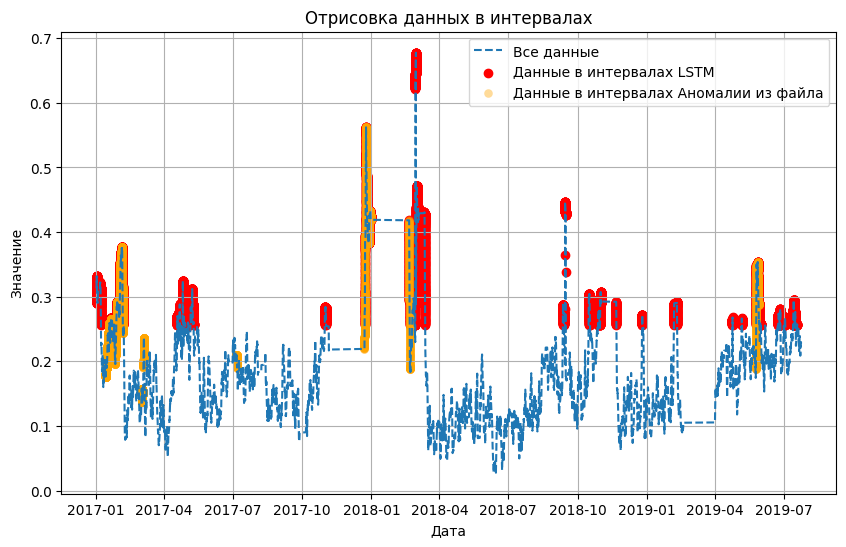

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


df['timestamp'] = pd.to_datetime(df['timestamp'])
# Определите интервалы
intervals = intervals
intervals_an = date_tuples

# Фильтруем DataFrame, чтобы получить только строки, которые находятся в интервалах
filtered_df = pd.DataFrame()
filtered_df_an = pd.DataFrame()

for interval in intervals:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df = pd.concat([filtered_df, interval_df])
print(filtered_df)
for interval in intervals_an:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df_an = pd.concat([filtered_df_an, interval_df])
print(filtered_df_an)

# Отрисовываем полученные данные
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['target_mean'], label='Все данные', linestyle='--')
plt.scatter(filtered_df['timestamp'], filtered_df['target_mean'], color='red', label='Данные в интервалах LSTM')
plt.scatter(filtered_df_an['timestamp'], filtered_df_an['target_mean'], color='orange', label='Данные в интервалах Аномалии из файла', alpha = 0.4,linewidths=0.1)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.title('Отрисовка данных в интервалах')
plt.grid(True)
plt.show()

In [20]:

import numpy as np
import pandas as pd

# Замените 'df' на вашу собственную переменную DataFrame
# и 'timestamp' на имя столбца с временными метками,
# 'value' на имя столбца со значениями

# Рассчитываем порог
short_threshold = np.percentile(df['target_value'], 90)

# Создаем список, чтобы хранить интервалы
intervals = []

# Инициализируем переменные для текущего интервала
current_interval_start = None
current_interval_end = None

# Проходимся по всем строкам DataFrame
for index, row in df.iterrows():
    timestamp = row['timestamp']  # Предполагается, что столбец 'timestamp' содержит временные метки
    # Если значение выше порога, начинаем новый интервал
    if row['target_mean'] > short_threshold:
        if current_interval_start is None:
            current_interval_start = timestamp
        current_interval_end = timestamp
    else:
        # Если значение ниже порога, закрываем текущий интервал
        if current_interval_start is not None:
            # Проверяем длительность интервала
            if current_interval_end - current_interval_start > pd.Timedelta(seconds=200):
                intervals.append((current_interval_start, current_interval_end))
            # Сбрасываем переменные текущего интервала
            current_interval_start = None
            current_interval_end = None

# Проверяем последний интервал после завершения цикла
if current_interval_start is not None:
    if current_interval_end - current_interval_start > pd.Timedelta(seconds=200):
        intervals.append((current_interval_start, current_interval_end))



In [24]:
import json
from datetime import datetime


# Преобразование интервалов в список словарей
interval_dicts = []

for start, end in intervals:
    interval_dict = {
        "start": str(start),
        "end": str(end),
        "duration_hours": (end - start).total_seconds() / 3600
    }
    interval_dicts.append(interval_dict)

# Преобразование в JSON
json_data = json.dumps(interval_dicts, indent=4)

# Сохранение JSON в файл
with open("intervals.json", "w") as json_file:
    json_file.write(json_data)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['timestamp'] = pd.to_datetime(df['timestamp'])
# Определите интервалы
intervals = intervals
intervals_an = date_tuples

# Фильтруем DataFrame, чтобы получить только строки, которые находятся в интервалах
filtered_df = pd.DataFrame()
filtered_df_an = pd.DataFrame()

for interval in intervals:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df = pd.concat([filtered_df, interval_df])
for interval in intervals_an:
    start_date, end_date = interval
    mask = (df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)
    interval_df = df.loc[mask]
    filtered_df_an = pd.concat([filtered_df_an, interval_df])

# Отрисовываем полученные данные
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['target_mean'], label='Все данные', linestyle='--')

# Отрисовываем интервалы
for interval in intervals_an:
    plt.axvspan(interval[0], interval[1], alpha=0.4, color='orange', label='Интервалы')

# Отрисовываем интервалы
for interval in intervals:
    plt.axvspan(interval[0], interval[1], alpha=0.4, color='red', label='Интервалы')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.title('Отрисовка данных в интервалах')
plt.grid(True)
plt.show()


In [ ]:
intervals

[]